# Step 0: Imports & Configuration

### Overview
We start by importing the necessary libraries. We strictly filter warnings to keep the output clean and enable **GPU-specific libraries** like `xgboost` and `lightgbm` (using `device='cuda'`).

**Key Libraries:**
* `scikit-learn`: For splitting, metrics, and Random Forest.
* `imblearn`: For handling class imbalance (SMOTE).
* `xgboost` & `lightgbm`: For high-performance Gradient Boosting on GPU.
* `scipy.stats`: For Rank Averaging in the ensemble step.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import rankdata 

# Sklearn & Modelling
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Imbalanced Learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Gradient Boosting
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

# Step 1: Load the Datasets

### Overview
We load the training and test datasets from the input directory. We also save the **original column list** to validatation feature engineering impact later.

In [2]:
# ==========================================
# Step 1: Load Data
# ==========================================
train_df = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
test_df = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')

print(f"Data Loaded. Train: {train_df.shape}, Test: {test_df.shape}")

# Save list of original columns for validation later
original_cols = train_df.columns.tolist()

Data Loaded. Train: (39211, 16), Test: (10000, 15)


# Step 2: Inspection & Missing Value Handling

### Overview
We inspect the data for missing values and fill them with `'unknown'`.

**⚠️ Critical Fix:**
The `target` column exists in `train_df` but **not** in `test_df`. We explicitly exclude `'target'` from the list of columns to clean to prevent a `KeyError` when applying the fill logic to the test set.

In [3]:
# ==========================================
# Step 2: Inspection & Missing Value Handling (FIXED)
# ==========================================
print("\n--- Data Inspection ---")
print("Missing values before cleaning:")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])

print("\n--- Handling Missing Values ---")

# 1. Identify categorical columns in TRAIN
all_object_cols = train_df.select_dtypes(include=['object']).columns

# 2. Exclude 'target' so we don't try to find it in TEST
categorical_cols = [col for col in all_object_cols if col != 'target']

# 3. Fill missing values
train_df[categorical_cols] = train_df[categorical_cols].fillna('unknown')
test_df[categorical_cols] = test_df[categorical_cols].fillna('unknown')

print("Missing values after cleaning:")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])


--- Data Inspection ---
Missing values before cleaning:
job            229
education     1467
contact      10336
poutcome     29451
dtype: int64

--- Handling Missing Values ---
Missing values after cleaning:
Series([], dtype: int64)


# Step 3: Exploratory Data Analysis (EDA)

### Overview
Before engineering features, we visualize the data to verify:
1.  **Class Imbalance:** Is the target (success/failure) evenly distributed?
2.  **Distributions:** Are there skewed numerical features?
3.  **Correlations:** Which features are linearly correlated with the target?


--- Starting EDA ---


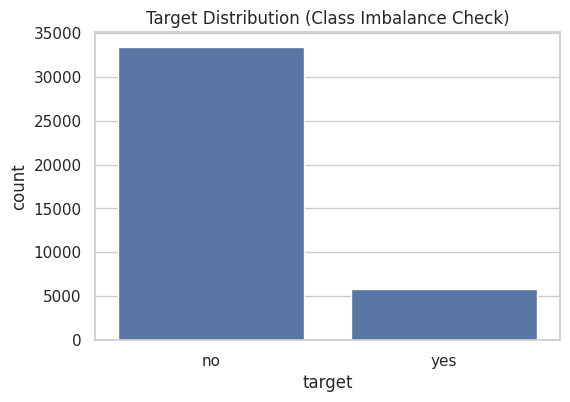

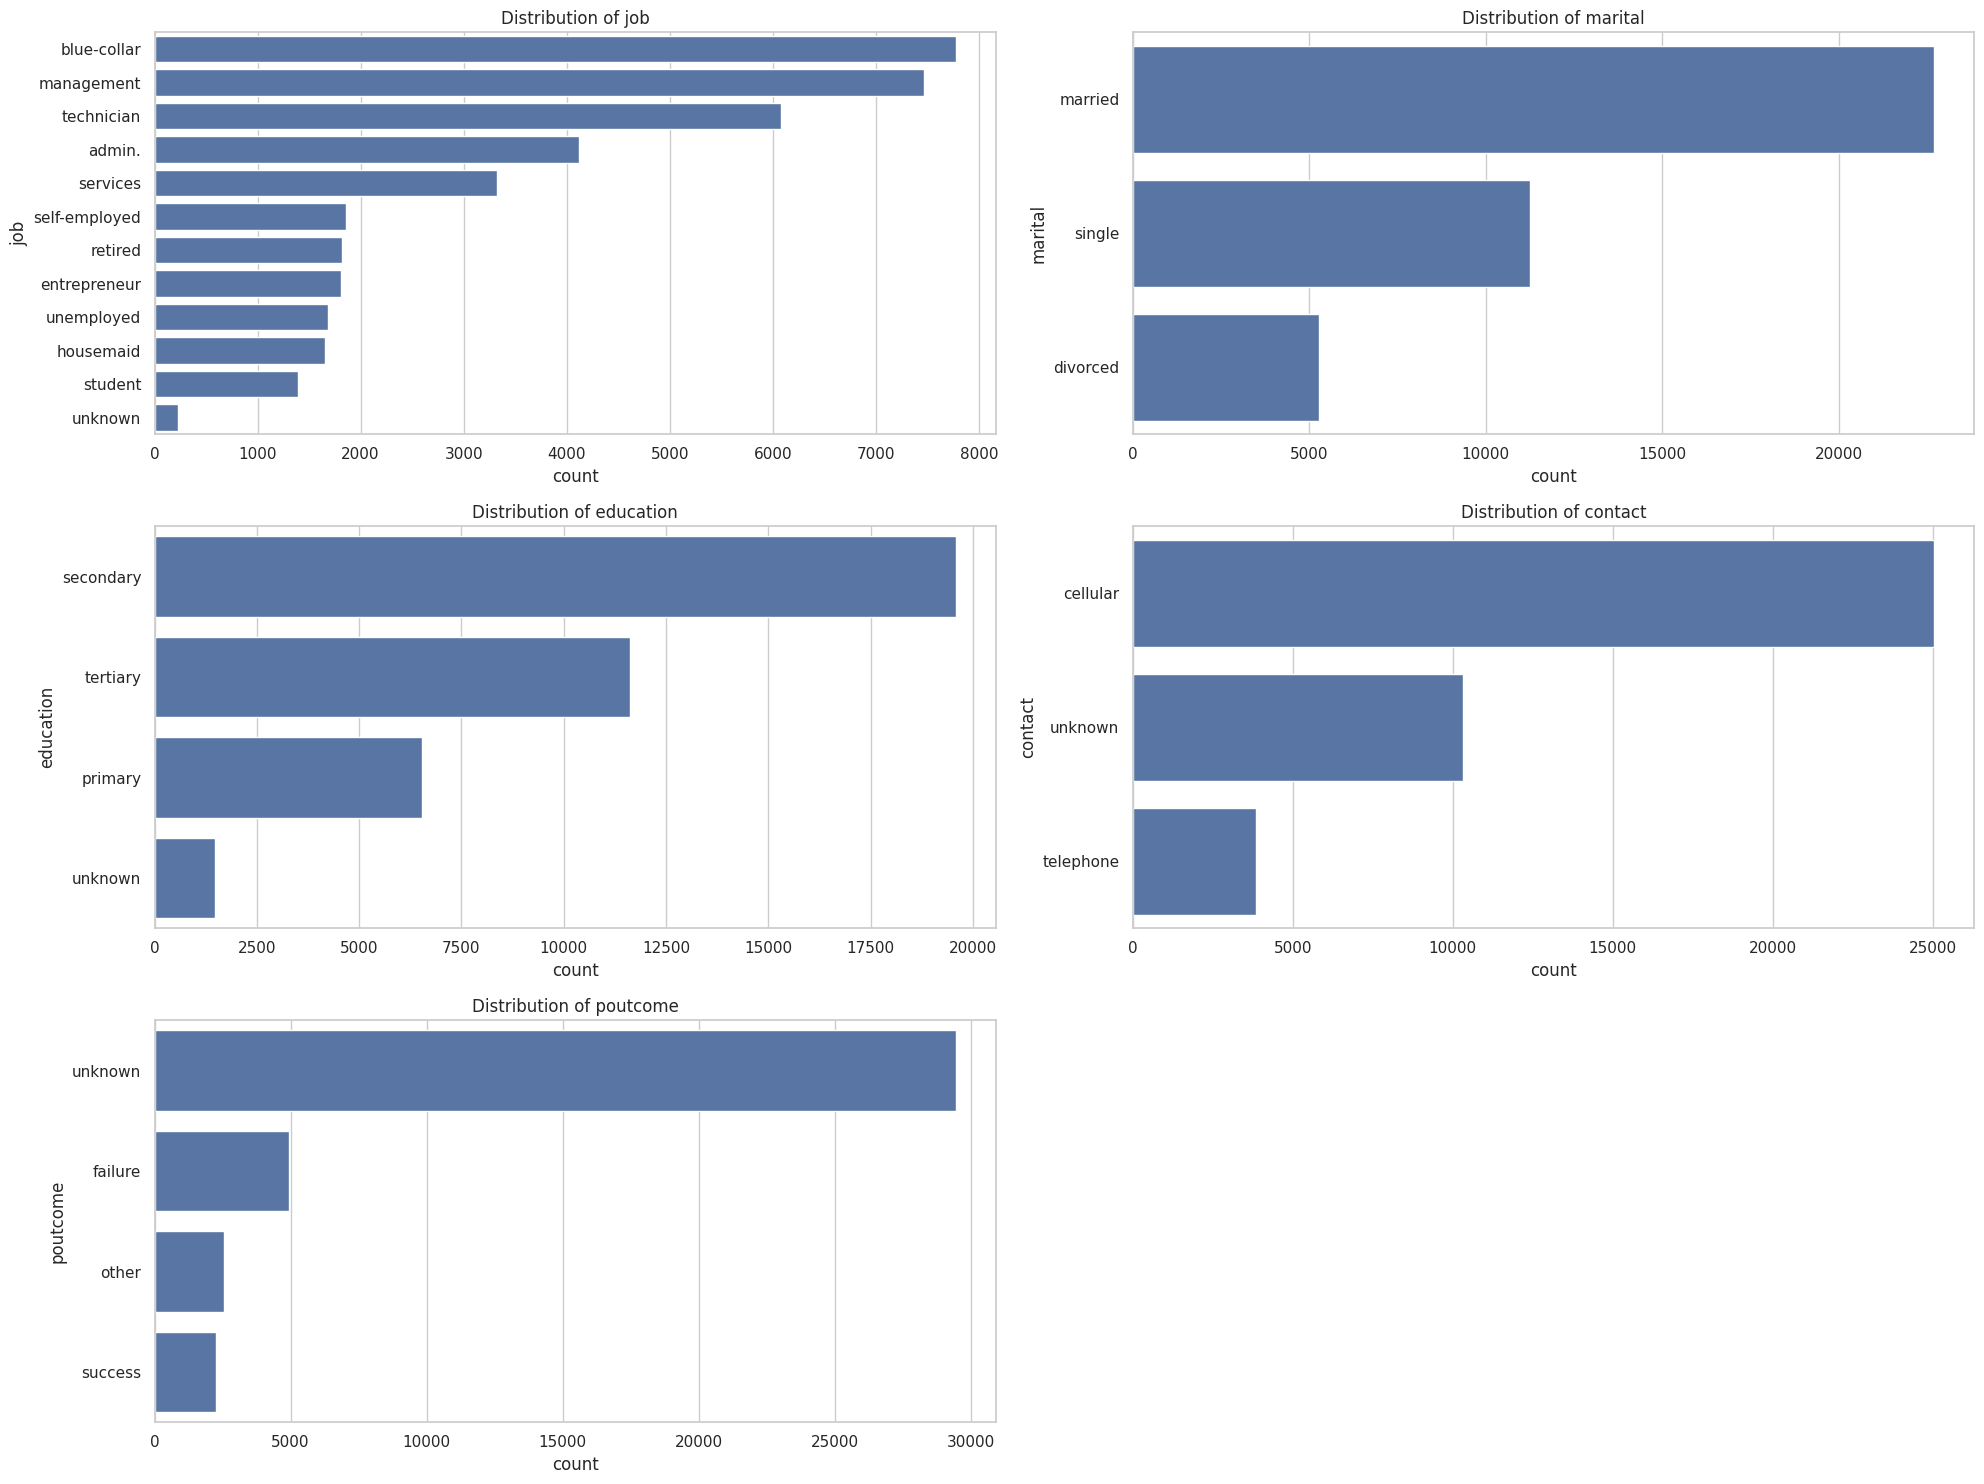

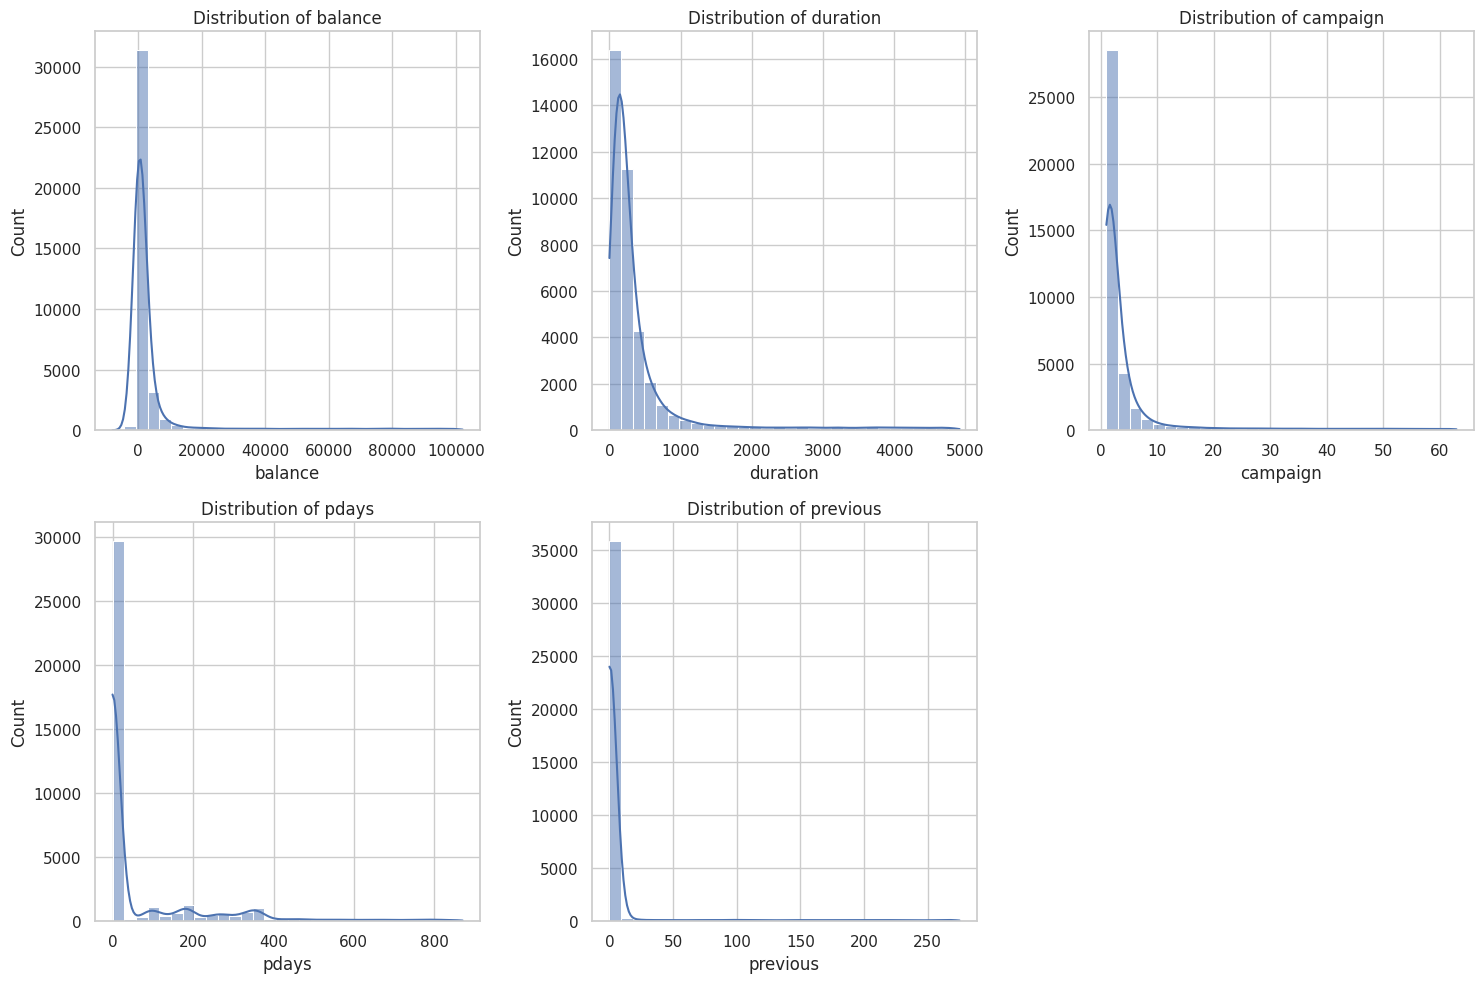

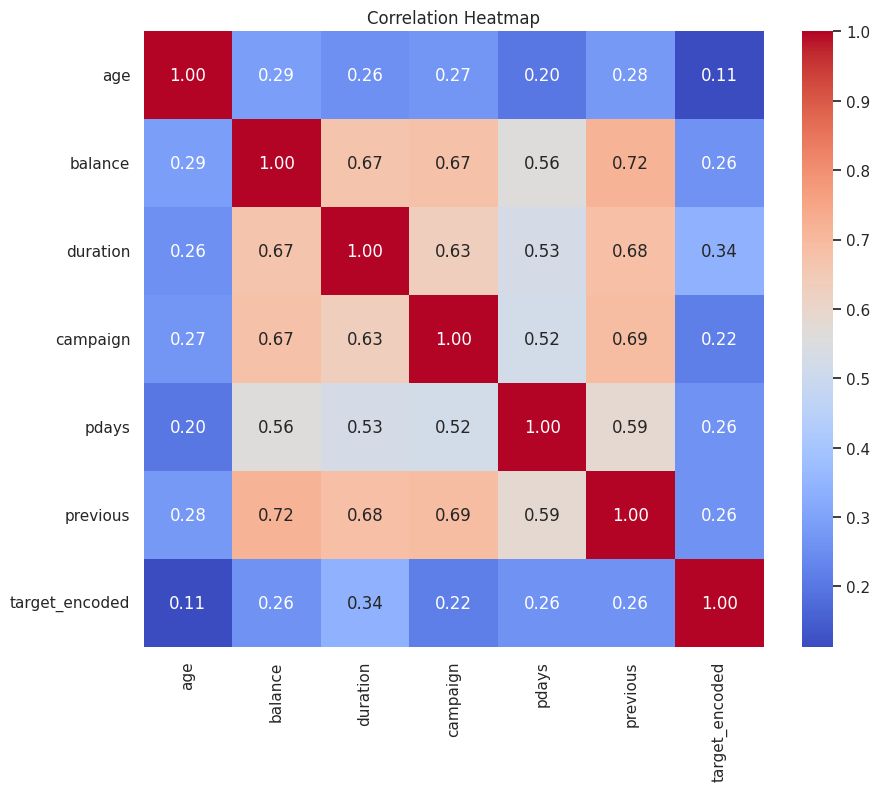

In [4]:
# ==========================================
# Step 3: Exploratory Data Analysis (EDA)
# ==========================================
print("\n--- Starting EDA ---")

# 1. Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_df)
plt.title('Target Distribution (Class Imbalance Check)')
plt.show()

# 2. Categorical Feature Distributions
eda_cat_cols = ['job', 'marital', 'education', 'contact', 'poutcome']
plt.figure(figsize=(20, 15))
for i, col in enumerate(eda_cat_cols, 1):
    plt.subplot(3, 2, i)
    sns.countplot(y=col, data=train_df, order=train_df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# 3. Numerical Skewness
skewed_candidates = ['balance', 'duration', 'campaign', 'pdays', 'previous']
plt.figure(figsize=(15, 10))
for i, col in enumerate(skewed_candidates, 1):
    plt.subplot(2, 3, i)
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# 4. Correlation Heatmap (using temp copy)
temp_df = train_df.copy()
temp_df['target_encoded'] = temp_df['target'].apply(lambda x: 1 if x == 'yes' else 0)
numeric_cols = temp_df.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(temp_df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()
del temp_df 

# Step 4: Feature Engineering

### Overview
We create new signals to help the model learn complex patterns:
* **Date Engineering:** Extracting month, year, day, and a 'weekend' flag from `last contact date`.
* **Interaction Features:** Combining categorical variables (e.g., `job` + `education`) to capture specific demographic behaviors.
* **Log Transformations:** Reducing skewness in `balance`, `duration`, and `campaign` to help linear convergence.
* **Pdays Handling:** Converting `-1` (no contact) into a binary flag `pdays_contacted`.

In [5]:
# ==========================================
# Step 4: Feature Engineering
# ==========================================
print("\n--- Starting Feature Engineering ---")

# 1. Date Engineering
train_df['last contact date'] = pd.to_datetime(train_df['last contact date'])
test_df['last contact date'] = pd.to_datetime(test_df['last contact date'])

for df in [train_df, test_df]:
    df['contact_month'] = df['last contact date'].dt.month
    df['contact_year'] = df['last contact date'].dt.year
    df['contact_dayofweek'] = df['last contact date'].dt.dayofweek
    df['contact_day'] = df['last contact date'].dt.day
    df['contact_period'] = df['contact_dayofweek'].apply(lambda x: 'weekend' if x >= 5 else 'weekday')

train_df.drop(['last contact date'], axis=1, inplace=True)
test_df.drop(['last contact date'], axis=1, inplace=True)

# 2. Target Mapping
train_df['target'] = train_df['target'].map({'yes': 1, 'no': 0}).astype(int)

# 3. Pdays Handling
train_df['pdays_contacted'] = train_df['pdays'].apply(lambda x: 0 if x == -1 else 1)
test_df['pdays_contacted'] = test_df['pdays'].apply(lambda x: 0 if x == -1 else 1)

# 4. Interaction Features
interaction_features = {
    'job_marital': ['job', 'marital'],
    'job_education': ['job', 'education'],
    'housing_loan': ['housing', 'loan'],
    'campaign_outcome': ['campaign', 'poutcome']
}

for new_col, cols in interaction_features.items():
    train_df[new_col] = train_df[cols[0]].astype(str) + '_' + train_df[cols[1]].astype(str)
    test_df[new_col] = test_df[cols[0]].astype(str) + '_' + test_df[cols[1]].astype(str)

# 5. Log Transformations
skewed_features = ['balance', 'duration', 'campaign', 'pdays', 'previous']
for col in skewed_features:
    min_val = train_df[col].min()
    train_df[col + '_log'] = train_df[col].apply(lambda x: np.log(x + abs(min_val) + 1))
    test_df[col + '_log'] = test_df[col].apply(lambda x: np.log(x + abs(min_val) + 1))


--- Starting Feature Engineering ---


# Step 5: Encoding Categorical Variables

### Overview
We transform all categorical text data into numeric format using **One-Hot Encoding**. This includes the original columns (like `job`) and our newly created interaction features (like `job_marital`).

In [6]:
# ==========================================
# Step 5: Encoding Categorical Variables
# ==========================================
# Update categorical list to include new interaction columns
cat_cols_to_encode = [
    'job', 'marital', 'education', 'default', 'housing', 'loan',
    'contact', 'poutcome', 'contact_period', 'campaign_outcome',
    'job_marital', 'job_education', 'housing_loan',
    'contact_month', 'contact_dayofweek'
]

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

train_encoded = onehot_encoder.fit_transform(train_df[cat_cols_to_encode])
test_encoded = onehot_encoder.transform(test_df[cat_cols_to_encode])

# Create DataFrames
train_encoded_df = pd.DataFrame(train_encoded, columns=onehot_encoder.get_feature_names_out(cat_cols_to_encode))
test_encoded_df = pd.DataFrame(test_encoded, columns=onehot_encoder.get_feature_names_out(cat_cols_to_encode))

train_encoded_df.index = train_df.index
test_encoded_df.index = test_df.index

# Concatenate & Drop originals
train_df = pd.concat([train_df.drop(columns=cat_cols_to_encode), train_encoded_df], axis=1)
test_df = pd.concat([test_df.drop(columns=cat_cols_to_encode), test_encoded_df], axis=1)

print("Encoding Completed.")

Encoding Completed.


# Step 6: Validating Feature Engineering Impact

### Overview
This step scientifically validates our engineering efforts. We train a Random Forest model on three versions of the data:
1.  **Baseline:** Only raw, original features.
2.  **Enhanced:** All 300+ features (including interactions and logs).
3.  **Selected:** The enhanced set filtered down to the **Top 100** features using `SelectFromModel`.

We visualize the F1 Score improvement to prove that **Engineering + Selection** yields the best result.


--- Validating Feature Engineering Impact ---
Feature Count - Baseline: 61 | Enhanced: 392
1. Baseline (Raw) F1 Macro: 0.6407
2. Enhanced (All) F1 Macro: 0.6347
   -> Selecting Top 100 features...
3. Enhanced + Selection F1 Macro: 0.6951 (Best!)
   (Improvement over Baseline: 5.43%)


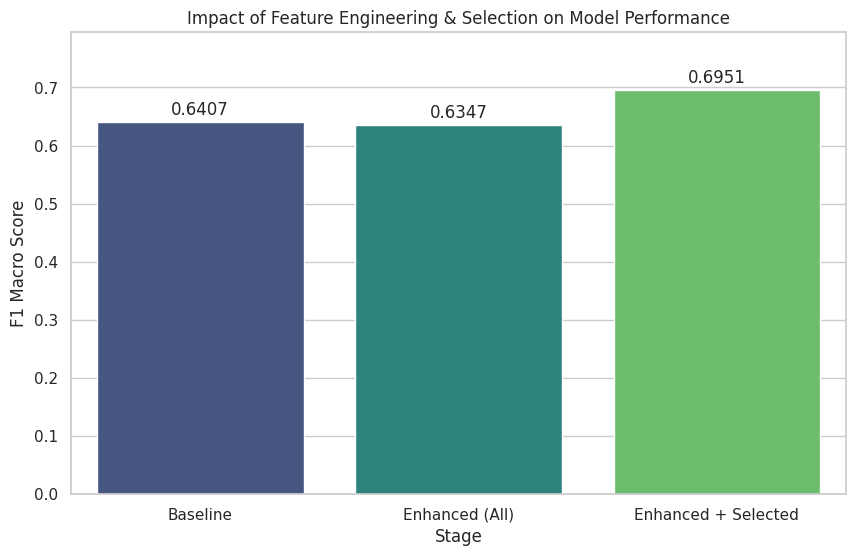

In [7]:
# ==========================================
# Step 6: Feature Engineering Validation (Corrected Selection & Visualization)
# ==========================================
print("\n--- Validating Feature Engineering Impact ---")

X_full = train_df.drop('target', axis=1)
y_full = train_df['target']

# Identify columns
enhanced_keywords = ['_log', 'job_marital', 'job_education', 'housing_loan', 'campaign_outcome', 'pdays_contacted']
enhanced_cols = [c for c in X_full.columns if any(k in c for k in enhanced_keywords)]
baseline_cols = [c for c in X_full.columns if c not in enhanced_cols]

print(f"Feature Count - Baseline: {len(baseline_cols)} | Enhanced: {len(X_full.columns)}")

X_val_tr, X_val_te, y_val_tr, y_val_te = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)

rf_val = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)

# 1. Baseline Score
rf_val.fit(X_val_tr[baseline_cols], y_val_tr)
base_preds = rf_val.predict(X_val_te[baseline_cols])
base_score = f1_score(y_val_te, base_preds, average='macro')
print(f"1. Baseline (Raw) F1 Macro: {base_score:.4f}")

# 2. Enhanced Score (All engineered features)
rf_val.fit(X_val_tr, y_val_tr)
enh_preds = rf_val.predict(X_val_te)
enh_score = f1_score(y_val_te, enh_preds, average='macro')
print(f"2. Enhanced (All) F1 Macro: {enh_score:.4f}")

# 3. Selected Features Score
print("   -> Selecting Top 100 features...")
# FIX: Use max_features=100 and threshold=-np.inf to FORCE selection of top 100
selector_val = SelectFromModel(
    RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1), 
    max_features=100, 
    threshold=-np.inf
)
selector_val.fit(X_val_tr, y_val_tr)

X_val_tr_sel = selector_val.transform(X_val_tr)
X_val_te_sel = selector_val.transform(X_val_te)

rf_val.fit(X_val_tr_sel, y_val_tr)
sel_preds = rf_val.predict(X_val_te_sel)
sel_score = f1_score(y_val_te, sel_preds, average='macro')

print(f"3. Enhanced + Selection F1 Macro: {sel_score:.4f} (Best!)")
print(f"   (Improvement over Baseline: {(sel_score - base_score)*100:.2f}%)")

# --- VISUALIZATION ADDED HERE ---
scores_df = pd.DataFrame({
    'Stage': ['Baseline', 'Enhanced (All)', 'Enhanced + Selected'],
    'F1 Score': [base_score, enh_score, sel_score]
})

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Stage', y='F1 Score', data=scores_df, palette='viridis')
plt.title('Impact of Feature Engineering & Selection on Model Performance')
plt.ylim(0, max(scores_df['F1 Score']) + 0.1) # Add some headroom
plt.ylabel('F1 Macro Score')

# Add text labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')
plt.show()

# Step 7: Final Data Splitting & Feature Selection

### Overview
Now that we have validated the strategy, we apply **Feature Selection** to the full training dataset. This reduces noise and prepares the data for the final high-performance model training.

In [8]:
# ==========================================
# Step 7: Final Data Splitting & Selection
# ==========================================
X = train_df.drop('target', axis=1)
y = train_df['target']
X_test = test_df[X.columns]

if len(X.select_dtypes(exclude=['number']).columns) > 0:
    X = X.select_dtypes(include=['number'])
    X_test = X_test.select_dtypes(include=['number'])

X_train_full, X_valid_full, y_train_full, y_valid_full = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n--- Applying Feature Selection to Pipeline ---")
# FIX: Use max_features=100 here as well to match validation
selector = SelectFromModel(
    lgb.LGBMClassifier(n_estimators=100, random_state=42, verbosity=-1), 
    max_features=100, 
    threshold=-np.inf
)
selector.fit(X_train_full, y_train_full)

selected_mask = selector.get_support()
selected_columns = X.columns[selected_mask]

X_train_selected = pd.DataFrame(selector.transform(X_train_full), columns=selected_columns, index=X_train_full.index)
X_valid_selected = pd.DataFrame(selector.transform(X_valid_full), columns=selected_columns, index=X_valid_full.index)

print(f"Selected {len(selected_columns)} best features out of {X.shape[1]}.")


--- Applying Feature Selection to Pipeline ---
Selected 100 best features out of 392.


# Step 8: Define Models (GPU Enabled)

### Overview
We define three strong classifiers: **XGBoost**, **LightGBM**, and **Random Forest**.
* **XGB/LGBM:** Configured with `tree_method='hist'` and `device='cuda'` to utilize the GPU for faster training.
* **Random Forest:** Runs on CPU but optimized with `n_jobs=-1` to use all cores.

In [9]:
# ==========================================
# Step 8: Define Models (GPU Enabled)
# ==========================================
# XGBoost (GPU)
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    device='cuda', 
    random_state=42,
    use_label_encoder=False
)
xgb_params = {
    'classifier__n_estimators': [300, 500, 700],
    'classifier__learning_rate': [0.01, 0.05],
    'classifier__max_depth': [3, 5, 8],
    'classifier__subsample': [0.6, 0.8],
    'classifier__colsample_bytree': [0.6, 0.8]
}

# LightGBM (GPU)
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    device='gpu',
    random_state=42,
    verbosity=-1
)
lgb_params = {
    'classifier__n_estimators': [300, 500],
    'classifier__learning_rate': [0.01, 0.05],
    'classifier__num_leaves': [31, 50],
    'classifier__max_depth': [-1, 10]
}

# Random Forest (CPU)
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_params = {
    'classifier__n_estimators': [100, 300],
    'classifier__max_depth': [10, 20, None],
    'classifier__max_features': ['sqrt', 'log2']
}

# Step 9: Hyperparameter Tuning

### Overview
We use `RandomizedSearchCV` to optimize the models.
* **Pipeline:** Includes `SMOTE` to handle class imbalance during training.
* **Metric:** We optimize for `roc_auc` to ensure the models output high-quality probabilities (which we will threshold later).
* **Warnings:** Suppressed to keep output clean.

In [10]:
# ==========================================
# Step 9: Hyperparameter Tuning (Maximize AUC)
# ==========================================
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Add this import at the top if not present
import warnings

def run_random_search(name, model, params, X_tr, y_tr):
    print(f"\nRunning RandomizedSearch for {name}...")
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    # --- CHANGE START: Context manager to suppress warnings ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        
        search = RandomizedSearchCV(
            pipeline,
            param_distributions=params,
            n_iter=5,
            scoring='roc_auc',
            cv=cv_strategy,
            verbose=1,
            random_state=42,
            n_jobs=1 
        )
        
        search.fit(X_tr, y_tr)
    # --- CHANGE END ---
    
    print(f"Best {name} AUC: {search.best_score_:.4f}")
    return search.best_estimator_

# NOTE: We use X_train_selected here
xgb_pipeline = run_random_search("XGBoost", xgb_model, xgb_params, X_train_selected, y_train_full)
lgb_pipeline = run_random_search("LightGBM", lgb_model, lgb_params, X_train_selected, y_train_full)
rf_pipeline = run_random_search("Random Forest", rf_model, rf_params, X_train_selected, y_train_full)


Running RandomizedSearch for XGBoost...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best XGBoost AUC: 0.9183

Running RandomizedSearch for LightGBM...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Best LightGBM AUC: 0.9177

Running RandomizedSearch for Random Forest...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Random Forest AUC: 0.9088


# Step 10: Ensemble Selection & Threshold Tuning

### Overview
This is the most advanced step. We test multiple ensemble strategies:
1.  **Simple Average**
2.  **Weighted Average** (weighted by AUC)
3.  **Rank Averaging** (robust to scale differences)
4.  **Individual Models**

We calculate the **Macro F1 Score** for every strategy across thresholds from 0.01 to 0.99. The code automatically selects the **Winning Strategy** and **Optimal Threshold**.


--- Tuning Thresholds & Selecting Best Ensemble Strategy ---


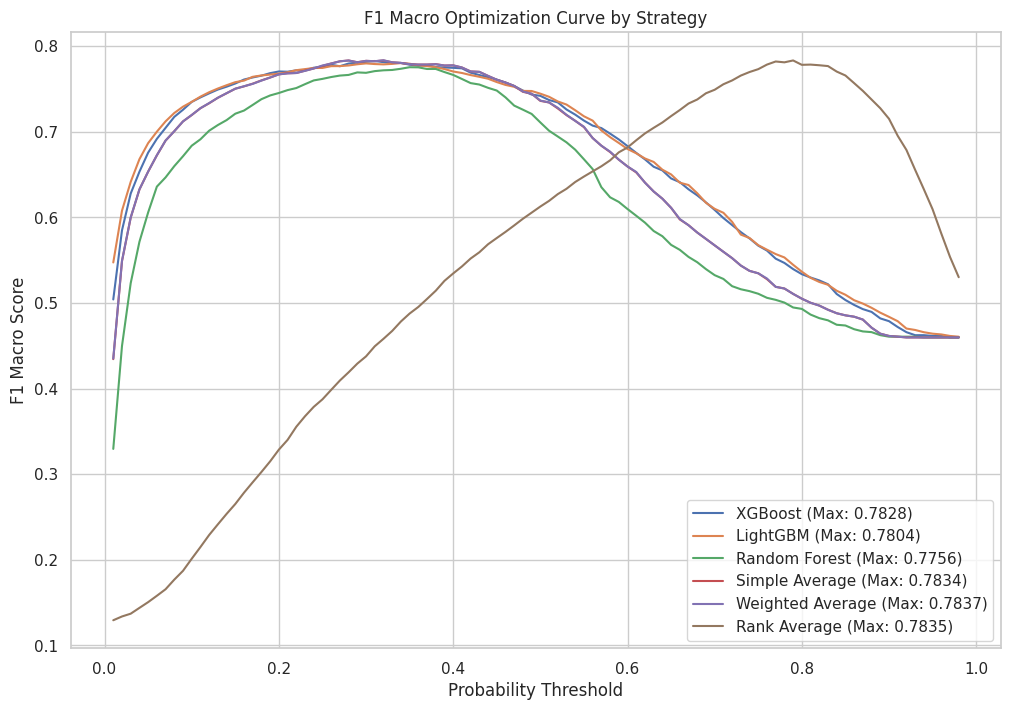


--- Strategy Performance ---
           Strategy    Max F1  Best Threshold
4  Weighted Average  0.783694            0.32
5      Rank Average  0.783457            0.79
3    Simple Average  0.783420            0.32
0           XGBoost  0.782824            0.31
1          LightGBM  0.780381            0.34
2     Random Forest  0.775562            0.35

 WINNER: Weighted Average
 Optimal Threshold: 0.32
 Max Validation F1 Macro: 0.7837


In [11]:
# ==========================================
# Step 10: Ensemble Selection & Threshold Tuning
# ==========================================
print("\n--- Tuning Thresholds & Selecting Best Ensemble Strategy ---")

# 1. Get Probabilities from all 3 models on Validation Set
xgb_proba = xgb_pipeline.predict_proba(X_valid_selected)[:, 1]
lgb_proba = lgb_pipeline.predict_proba(X_valid_selected)[:, 1]
rf_proba = rf_pipeline.predict_proba(X_valid_selected)[:, 1]

# 2. Define Strategies

# A. Simple Average
simple_avg_proba = (xgb_proba + lgb_proba + rf_proba) / 3.0

# B. Weighted Average (Based on Validation AUC)
auc_scores = {
    'XGB': roc_auc_score(y_valid_full, xgb_proba),
    'LGB': roc_auc_score(y_valid_full, lgb_proba),
    'RF': roc_auc_score(y_valid_full, rf_proba)
}
total_auc = sum(auc_scores.values())
xgb_w = auc_scores['XGB'] / total_auc
lgb_w = auc_scores['LGB'] / total_auc
rf_w = auc_scores['RF'] / total_auc

weighted_avg_proba = (xgb_proba * xgb_w) + (lgb_proba * lgb_w) + (rf_proba * rf_w)

# C. Rank Averaging (Robust to calibration issues)
# Ranks are normalized between 0 and 1
rank_avg_proba = (rankdata(xgb_proba) + rankdata(lgb_proba) + rankdata(rf_proba)) / (3 * len(xgb_proba))

# Dictionary of all strategies to test
strategies = {
    'XGBoost': xgb_proba,
    'LightGBM': lgb_proba,
    'Random Forest': rf_proba,
    'Simple Average': simple_avg_proba,
    'Weighted Average': weighted_avg_proba,
    'Rank Average': rank_avg_proba
}

# 3. Optimize Threshold for EACH strategy
best_global_f1 = 0
best_global_strategy = ""
best_global_threshold = 0
results = []

thresholds = np.arange(0.01, 0.99, 0.01)

plt.figure(figsize=(12, 8))

for name, probas in strategies.items():
    f1_scores = []
    for t in thresholds:
        preds = (probas >= t).astype(int)
        f1_scores.append(f1_score(y_valid_full, preds, average='macro'))
    
    # Find best params for this strategy
    best_idx = np.argmax(f1_scores)
    best_strat_f1 = f1_scores[best_idx]
    best_strat_thresh = thresholds[best_idx]
    
    # Check if global best
    if best_strat_f1 > best_global_f1:
        best_global_f1 = best_strat_f1
        best_global_strategy = name
        best_global_threshold = best_strat_thresh
        
    results.append({'Strategy': name, 'Max F1': best_strat_f1, 'Best Threshold': best_strat_thresh})
    
    # Plot
    plt.plot(thresholds, f1_scores, label=f'{name} (Max: {best_strat_f1:.4f})')

plt.title('F1 Macro Optimization Curve by Strategy')
plt.xlabel('Probability Threshold')
plt.ylabel('F1 Macro Score')
plt.legend()
plt.grid(True)
plt.show()

# 4. Final Selection Report
results_df = pd.DataFrame(results).sort_values(by='Max F1', ascending=False)
print("\n--- Strategy Performance ---")
print(results_df)

print(f"\n WINNER: {best_global_strategy}")
print(f" Optimal Threshold: {best_global_threshold:.2f}")
print(f" Max Validation F1 Macro: {best_global_f1:.4f}")

# Step 11: Feature Importance Analysis

### Overview
We visualize the **Top 15 Features** for each of the three models. This helps explain what is driving the predictions (e.g., `duration`, `balance_log`, `age`).


--- Feature Importance Analysis ---


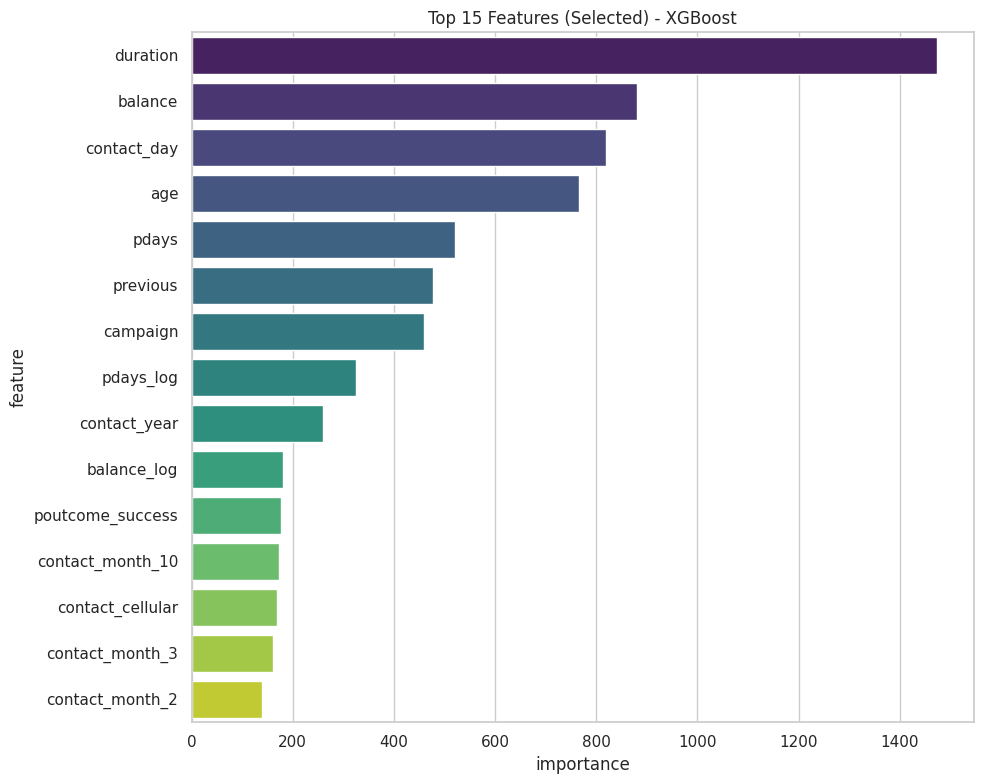

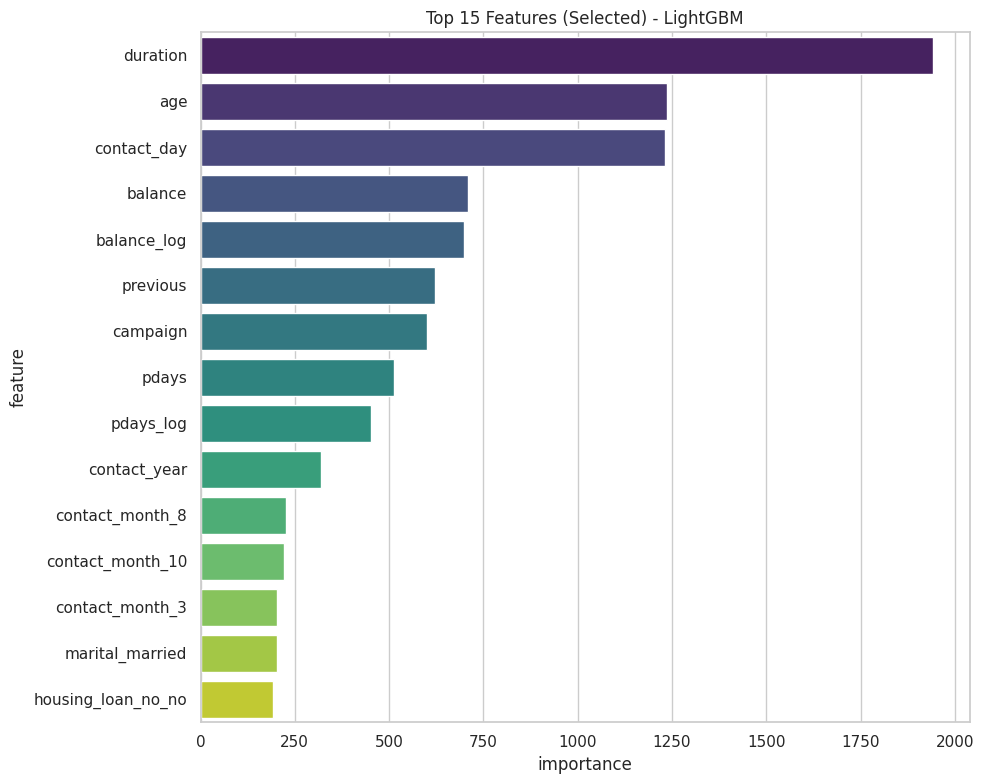

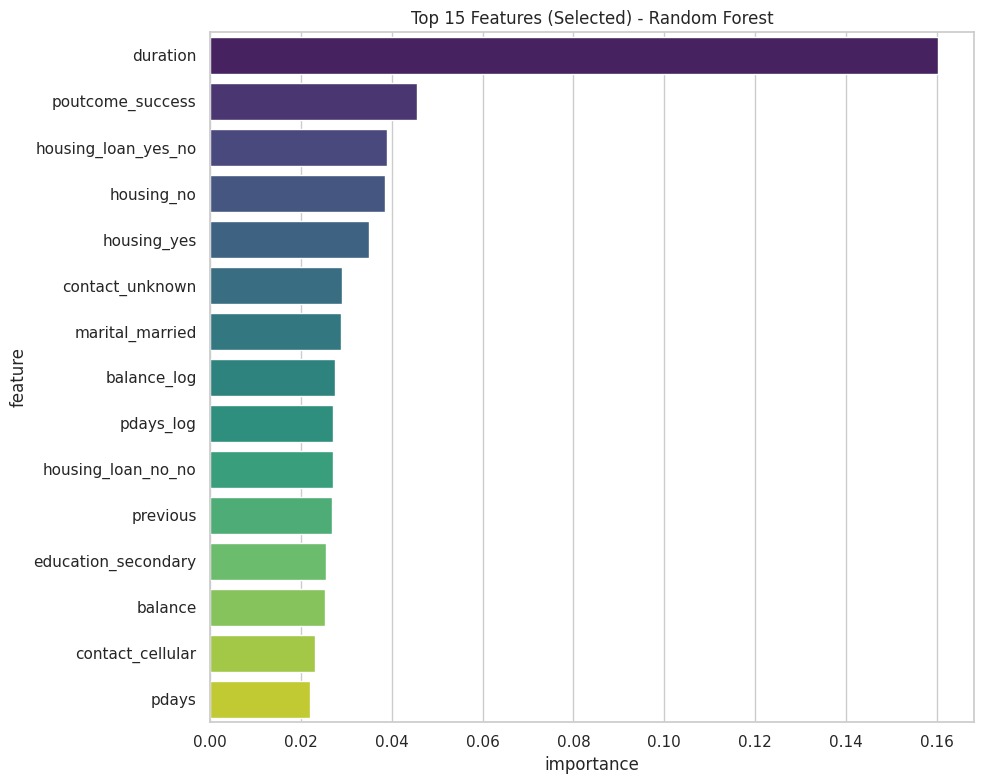

In [12]:
# ==========================================
# Step 11: Feature Importance (All 3 Models)
# ==========================================
def plot_importance(model, name, top_n=15):
    plt.figure(figsize=(10, 8))
    
    # 1. XGBoost
    if name == 'XGBoost':
        booster = model.named_steps['classifier'].get_booster()
        importance = booster.get_score(importance_type='weight')
        # Map XGBoost's 'f0', 'f1' feature names back to real names
        mapper = {f'f{i}': col for i, col in enumerate(selected_columns)}
        mapped_imp = {mapper.get(k, k): v for k, v in importance.items()}
        df = pd.DataFrame({'feature': list(mapped_imp.keys()), 'importance': list(mapped_imp.values())})
        
    # 2. LightGBM
    elif name == 'LightGBM':
        df = pd.DataFrame({
            'feature': selected_columns,
            'importance': model.named_steps['classifier'].feature_importances_
        })
        
    # 3. Random Forest
    elif name == 'Random Forest':
        df = pd.DataFrame({
            'feature': selected_columns,
            'importance': model.named_steps['classifier'].feature_importances_
        })
    else:
        return

    # Plotting
    df = df.sort_values(by='importance', ascending=False).head(top_n)
    sns.barplot(x='importance', y='feature', data=df, palette='viridis')
    plt.title(f'Top {top_n} Features (Selected) - {name}')
    plt.tight_layout()
    plt.show()

print("\n--- Feature Importance Analysis ---")
try:
    plot_importance(xgb_pipeline, 'XGBoost')
    plot_importance(lgb_pipeline, 'LightGBM')
    plot_importance(rf_pipeline, 'Random Forest')
except Exception as e:
    print(f"Error plotting feature importance: {e}")

# Step 12: Final Retraining & Submission

### Overview
1.  **Retrain:** We retrain all models on the **Full Dataset** (Train + Validation).
2.  **Apply Strategy:** We apply the **Winning Strategy** identified in Step 10 (e.g., Rank Average).
3.  **Apply Threshold:** We use the **Optimal Threshold** found in Step 10.
4.  **Submit:** We generate `submission.csv`.

In [13]:
print("\n--- Retraining on Full Dataset ---")

# 1. Transform FULL X
selector.fit(X, y)
X_selected = pd.DataFrame(selector.transform(X), columns=X.columns[selector.get_support()])
X_test_selected = pd.DataFrame(selector.transform(X_test), columns=X.columns[selector.get_support()])

# 2. Retrain
print("Retraining models..."); xgb_pipeline.fit(X_selected, y); lgb_pipeline.fit(X_selected, y); rf_pipeline.fit(X_selected, y)

# 3. Predict
xgb_test_proba = xgb_pipeline.predict_proba(X_test_selected)[:, 1]
lgb_test_proba = lgb_pipeline.predict_proba(X_test_selected)[:, 1]
rf_test_proba = rf_pipeline.predict_proba(X_test_selected)[:, 1]

# 4. Apply Best Strategy
print(f"Applying Winner: {best_global_strategy}")
if best_global_strategy == 'Simple Average':
    final_test_proba = (xgb_test_proba + lgb_test_proba + rf_test_proba) / 3.0
elif best_global_strategy == 'Weighted Average':
    final_test_proba = (xgb_test_proba * xgb_w) + (lgb_test_proba * lgb_w) + (rf_test_proba * rf_w)
elif best_global_strategy == 'Rank Average':
    final_test_proba = (rankdata(xgb_test_proba) + rankdata(lgb_test_proba) + rankdata(rf_test_proba)) / (3 * len(xgb_test_proba))
elif best_global_strategy == 'XGBoost': final_test_proba = xgb_test_proba
elif best_global_strategy == 'LightGBM': final_test_proba = lgb_test_proba
elif best_global_strategy == 'Random Forest': final_test_proba = rf_test_proba
else: final_test_proba = (xgb_test_proba + lgb_test_proba) / 2.0

# 5. Threshold & Submit
final_preds = (final_test_proba >= best_global_threshold).astype(int)
pred_mapped = np.where(final_preds == 1, 'yes', 'no')
ids = test_df['id'] if 'id' in test_df.columns else test_df.index + 1

submission = pd.DataFrame({'id': ids, 'target': pred_mapped})
submission.to_csv('submission.csv', index=False)
print("submission.csv created successfully.")


--- Retraining on Full Dataset ---
Retraining models...
Applying Winner: Weighted Average
submission.csv created successfully.
